# Gaussian Processes for Classification

## 1. Generate two classes of data with the same population size (N1=N2=50), sigma = 0.1, mean1 = [2,2], mean2= [3,3]:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from numpy.linalg import pinv
%matplotlib inline

In [2]:
N1 = 50
N2 = 50
sigma = 0.1
K=2

In [3]:
def generate_classification_data(N1, N2, K, sigma):
    mean = (2, 2)
    cov = [[sigma, 0], [0, sigma]]
    X1 = random.multivariate_normal(mean, cov, N1)
    c1 = ['maroon'] * len(X1)

    mean = (3, 3)
    cov = [[sigma, 0], [0, sigma]]
    X2 = random.multivariate_normal(mean, cov, N2)
    c2 = ['navy'] * len(X2)

    X = np.concatenate((X1, X2))
    color = np.concatenate((c1, c2))
    
    fig = plt.figure()
    plt.scatter(X[ : , 0], X[: , 1], marker='o', c=color)
    plt.show
    
    data = [X, X1, X2, color]
    return data, fig

## 2. Write code of Gaussian Processes to classify the two clusters.

### Functions for Training Stage to calculate $\mathbb{C}_n, \overline a_N^{new}$ and $\mathbb{W}_N$

In [4]:
def calculate_a(w, x):
    return w.transpose().dot(x).transpose()

# def insert_dummy_values(arr):
#     dummy_arr = np.ones((arr.shape[0], 1))
#     return np.hstack((arr, dummy_arr))

def calculate_sigmoid(a):
    return 1 / (1 + np.exp(-a))

def calculate_Cn(kernel, X, v):    
    Cn = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            if (m==n):
                Cn[m][n] = kernel(X[m], X[n]) + v
            else:
                Cn[m][n] = kernel(X[m], X[n])
    return Cn

def calculate_W(sigmoid):
    N = sigmoid.shape[0]
    W = np.zeros((N, N))
    for n in range(N):
        W[n][n] = sigmoid[n] * (1 - sigmoid[n])
    return W

def calculate_T(X, N1, N2, K):
    N = N1 + N2
    T = np.zeros((N, 1))
    for n in range(N):
        if (n<N1):
            T[n] = 0
        if (n>=N1 and n<N):
            T[n] = 1
    T = T.astype(int)
    return T

### Newton's Method to find $\overline a_{new}$

In [5]:
def calculate_delta_Ew(Cn, a, T, sigmoid):
    return T - sigmoid - pinv(Cn).dot(a)

def calculate_hessian(Cn, W):
    return pinv(Cn) + W

def calculate_new_a(a, hessian, delta_Ew):
    return a + pinv(hessian).dot(delta_Ew)

### Testing Phase

### Create the Kernel

In [6]:
class Kernel(object):
    def __init__(self, *args):
        self.thetas = args
    
    def __call__(self, x, y):
        exp = self.thetas[0] * np.exp( -0.5 * self.thetas[1] * (( x - y ).T.dot(x-y)) )
        linear = self.thetas[3] * (x.T.dot(y))
        constant = self.thetas[2]
        return (exp + constant + linear)

### Running Newton's Method

In [7]:
def newton_method(a_old, iter_num, Cn, T):
    for i in range(iter_num):
        sigmoid = calculate_sigmoid(a_old)
        W = calculate_W(sigmoid)

        delta_Ew = calculate_delta_Ew(Cn, a_old, T, sigmoid)
        hessian = calculate_hessian(Cn, W)
        a_new = calculate_new_a(a_old, hessian, delta_Ew)
        a_old = a_new
    return a_new, W

### Finding the mean and variance of $\overline a_{new}$

In [8]:
x = np.arange(0, 5, 0.05)
y = np.arange(0, 5, 0.05)
kernel = Kernel(1.0, 4.0, 1.0, 2.0)
N1 = 50
N2 = 50
N = N1 + N2
sigma = 0.1

In [9]:
def classify(x, y, N1, N2, K, sigma, kernel):
    data, fig = generate_classification_data(N1, N2, K, sigma)
    X = data[0]
    N = N1 + N2
    Cn = calculate_Cn(kernel, X, 1)
    a_old = np.zeros((N1 + N2, 1))
    iter_num = 20
    T = calculate_T(X, N1, N2, K)
    a_new, W = newton_method(a_old, iter_num, Cn, T)

    probabilities = np.zeros((len(x), len(y)))
    # for each point on the graph
    for n in range(len(x)):
        for m in range(len(y)):
            x_star = np.zeros((K, 1))
            x_star[0] = x[n]
            x_star[1] = y[m]
            c_star = kernel(x_star, x_star) + 1

            # for each training data point
            k_bar = np.zeros((N,1))
            for d in range(N):
                k = kernel(X[d].reshape(K, 1), x_star)
                k = np.asscalar(k)
                k_bar[d] = k
            mu_star = k_bar.T.dot(pinv(Cn)).dot(a_new)
            mu_star = np.asscalar(mu_star)
            s_star = c_star - k_bar.T.dot(pinv(pinv(W) + Cn)).dot(k_bar)
            s_star = np.asscalar(s_star)
            sigmoid_input = mu_star / np.sqrt(1 + ((np.pi / 8) * (s_star **2)))
            prob = calculate_sigmoid(sigmoid_input)
            probabilities[n][m] = prob
    return probabilities

In [10]:
def plot_classification(N1, N2, K, sigma, kernel):
    mean = (2, 2)
    cov = [[sigma, 0], [0, sigma]]
    X1 = random.multivariate_normal(mean, cov, N1)
    c1 = ['maroon'] * len(X1)

    mean = (3, 3)
    cov = [[sigma, 0], [0, sigma]]
    X2 = random.multivariate_normal(mean, cov, N2)
    c2 = ['navy'] * len(X2)

    X = np.concatenate((X1, X2))
    color = np.concatenate((c1, c2))

    fig = plt.figure()
    plt.scatter(X[ : , 0], X[: , 1], marker='o', c=color, figure=fig)
    probabilities = classify(x, y, N1, N2, K, sigma, kernel)
    prob = np.rot90(probabilities)
    plt.imshow(prob, cmap = 'jet', extent=[0, 5, 0, 5])

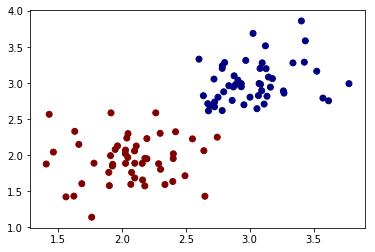

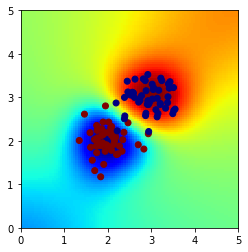

In [11]:
plot_classification(N1, N2, K, sigma, kernel)

## 3. Change the kernel parameters to (1.0, 0.25, 0, 0)

In [12]:
kernel = Kernel(1.0, 0.25, 0.0, 0.0)

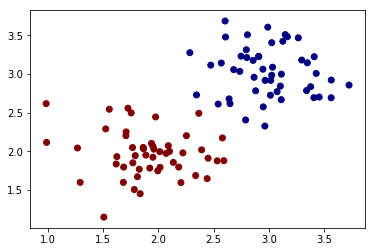

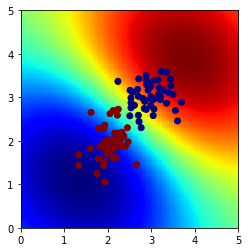

In [13]:
plot_classification(N1, N2, K, sigma, kernel)

## 6. Discuss why the new parameters generate a less precise probability map.

The new parameters cause each value of $\overline k$ to be much higher. This is because decreasing the 2nd value of $\theta$ causes the exponential term to be much higher. As a result, when the value of $\mu_{*}$ will be away from the first $\mu_{*}$ as well.

## 7. Change the kernel parameters back to (1.0, 4.0, 1.0, 2.0).

In [14]:
kernel = Kernel(1.0, 4.0, 1.0, 2.0)

## 8. Change the means of the clusters to mean1 = [3,3], mean2= [3.2,3.2], and cov1 = [[0.003, 0],[0, 0.003]], cov2= [[0.3,0],[0,0.3]]:	

In [15]:
def generate_classification_data(N1, N2, K, sigma):
    mean = (3, 3)
    cov = [[0.003, 0], [0, 0.003]]
    X1 = random.multivariate_normal(mean, cov, N1)
    c1 = ['maroon'] * len(X1)

    mean = (3.2, 3.2)
    cov = [[0.3, 0], [0, 0.3]]
    X2 = random.multivariate_normal(mean, cov, N2)
    c2 = ['navy'] * len(X2)

    X = np.concatenate((X1, X2))
    color = np.concatenate((c1, c2))

    fig = plt.figure()
    plt.scatter(X[ : , 0], X[: , 1], marker='o', c=color, figure=fig)
    
    data = [X, X1, X2, color]
    return data, fig

def plot_classification(N1, N2, K, sigma, kernel):
    data = generate_classification_data(N1, N2, K, sigma)
    probabilities = classify(x, y, N1, N2, K, sigma, kernel)
    prob = np.rot90(probabilities)
    plt.imshow(prob, cmap = 'jet', extent=[0, 5, 0, 5])

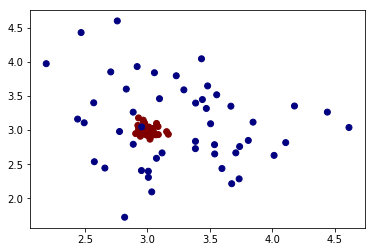

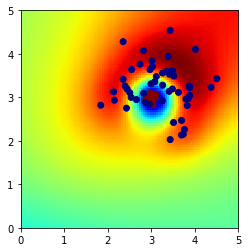

In [16]:
plot_classification(N1, N2, K, sigma, kernel)

## 9. Change the means and clusters back to #1 above, and add another cluster belonging to C2, with mean=[1,1] and sigma=0.1

In [17]:
def generate_classification_data(N1, N2, K, sigma):
    mean = (2, 2)
    cov = [[sigma, 0], [0, sigma]]
    X1 = random.multivariate_normal(mean, cov, N1)
    c1 = ['maroon'] * len(X1)

    mean = (3, 3)
    cov = [[sigma, 0], [0, sigma]]
    X2 = random.multivariate_normal(mean, cov, N2)
    c2 = ['navy'] * len(X2)

    mean = (1, 1)
    cov = [[sigma, 0], [0, sigma]]
    X3 = random.multivariate_normal(mean, cov, N2)
    c3 = ['navy'] * len(X3)

    X = np.concatenate((X1, X2, X3))
    color = np.concatenate((c1, c2, c3))

    plt.figure()
    plt.scatter(X[ : , 0], X[: , 1], marker='o', c=color)
    
    data = [X, X1, X2, color]
    return data

## 11. Classify and show the probability map: 

In [18]:
def calculate_a(w, x):
    return w.transpose().dot(x).transpose()

def calculate_sigmoid(a):
    return 1 / (1 + np.exp(-a))

def calculate_Cn(kernel, X, v):    
    N = N1 + N2 *2
    Cn = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            if (m==n):
                Cn[m][n] = kernel(X[m], X[n]) + v
            else:
                Cn[m][n] = kernel(X[m], X[n])
    return Cn

def calculate_W(sigmoid):
    N = N1 + N2 *2
    W = np.zeros((N, N))
    for n in range(N):
        W[n][n] = sigmoid[n] * (1 - sigmoid[n])
    return W

def calculate_T(X, N1, N2, K):
    N = N1 + N2 *2
    T = np.zeros((N, 1))
    for n in range(N):
        if (n<N1):
            T[n] = 0
        if (n>=N1 and n<N):
            T[n] = 1
    T = T.astype(int)
    return T

def calculate_delta_Ew(Cn, a, T, sigmoid):
    return T - sigmoid - pinv(Cn).dot(a)

def calculate_hessian(Cn, W):
    return pinv(Cn) + W

def calculate_new_a(a, hessian, delta_Ew):
    return a + pinv(hessian).dot(delta_Ew)

def newton_method(a_old, iter_num, Cn, T):
    for i in range(iter_num):
        sigmoid = calculate_sigmoid(a_old)
        W = calculate_W(sigmoid)

        delta_Ew = calculate_delta_Ew(Cn, a_old, T, sigmoid)
        hessian = calculate_hessian(Cn, W)
        a_new = calculate_new_a(a_old, hessian, delta_Ew)
        a_old = a_new
    return a_new, W

def classify(x, y, N1, N2, K, sigma, kernel):
    data = generate_classification_data(N1, N2, K, sigma)
    X = data[0]
    N = N1 + N2 * 2
    Cn = calculate_Cn(kernel, X, 1)
    a_old = np.zeros((N, 1))
    iter_num = 20
    T = calculate_T(X, N1, N2, K)
    a_new, W = newton_method(a_old, iter_num, Cn, T)

    probabilities = np.zeros((len(x), len(y)))
    # for each point on the graph
    for n in range(len(x)):
        for m in range(len(y)):
            x_star = np.zeros((K, 1))
            x_star[0] = x[n]
            x_star[1] = y[m]
            c_star = kernel(x_star, x_star) + 1

            # for each training data point
            k_bar = np.zeros((N,1))
            for d in range(N):
                k = kernel(X[d].reshape(K, 1), x_star)
                k = np.asscalar(k)
                k_bar[d] = k
            mu_star = k_bar.T.dot(pinv(Cn)).dot(a_new)
            mu_star = np.asscalar(mu_star)
            s_star = c_star - k_bar.T.dot(pinv(pinv(W) + Cn)).dot(k_bar)
            s_star = np.asscalar(s_star)
            sigmoid_input = mu_star / np.sqrt(1 + ((np.pi / 8) * (s_star **2)))
            prob = calculate_sigmoid(sigmoid_input)
            probabilities[n][m] = prob
    return probabilities

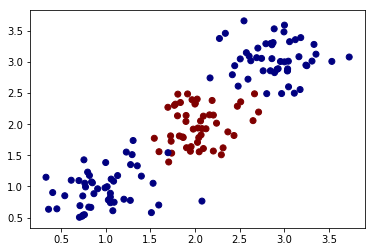

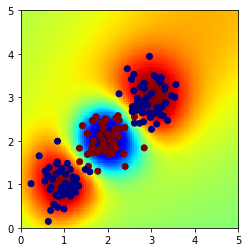

In [19]:
plot_classification(N1, N2, K, sigma, kernel)

## 12. Show the probability maps of the predictive distribution on the data described at #1 and #8 above.

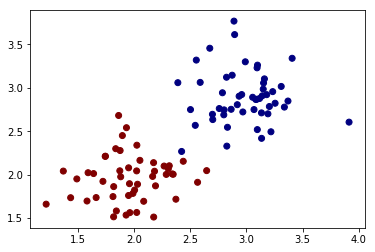

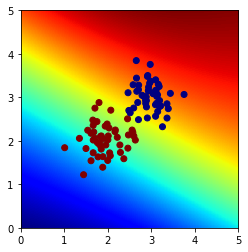

In [20]:
N1 = 50
N2 = 50
sigma = 0.1
K=2

def generate_classification_data(N1, N2, K, sigma):
    mean = (2, 2)
    cov = [[sigma, 0], [0, sigma]]
    X1 = random.multivariate_normal(mean, cov, N1)
    c1 = ['maroon'] * len(X1)

    mean = (3, 3)
    cov = [[sigma, 0], [0, sigma]]
    X2 = random.multivariate_normal(mean, cov, N2)
    c2 = ['navy'] * len(X2)

    X = np.concatenate((X1, X2))
    color = np.concatenate((c1, c2))
    
    fig = plt.figure()
    plt.scatter(X[ : , 0], X[: , 1], marker='o', c=color)
    plt.show
    
    data = [X, X1, X2, color]
    return data

data = generate_classification_data(N1, N2, K, sigma)

def calculate_T(X, X1, X2, K):
    T = np.zeros([len(X), K])
    for n in range(0, len(X)):
        if (n<len(X1)):
            T[n][0] = 1
        if (n>=N1 and n<len(X1) + len(X2)):
            T[n][1] = 1
    T = T.astype(int)
    return T

X = data[0]
X1 = data[1]
X2 = data[2]
color = data[3]

T = calculate_T(X, X1, X2, K)

def calculate_sigmoid(a):
    s = 1 / (1 + np.exp(-a))
    return s

def calculate_phi(x):
    return x

def calculate_hessian(cov, w_prior, phi, N1, N2):
    right_side = 0
    for n in range(N1 + N2):
        phi_n = phi[n].reshape(2, 1)
        a = w_prior.T.dot(phi_n)
        sigmoid = calculate_sigmoid(a)
        right_side += sigmoid * (1 - sigmoid) * phi_n.dot(phi_n.transpose())
    hessian = pinv(cov) + right_side
    return hessian

def calculate_delta_Ew(cov, w_prior, phi, T, N1, N2):
    right_side = 0
    for n in range(N1 + N2):
        a = w_prior.T.dot(phi[n])
        sigmoid = calculate_sigmoid(a)
        t = np.argmax(T[n])
        right_side += (sigmoid - t) *(phi[n])
    delta_Ew  = (pinv(cov).dot(w_prior - 0).transpose() + right_side).transpose()
    return delta_Ew

def newton_method(w_prior, s0, phi, T, iter_num=1):
    """ 
    Steps to calculate Newton's method:
    1) w_new = w_old - hessian_inv dot delta_Ew
    2) w_new becomes w_old and used to calculate the w_new again
    """
    w_old = w_prior
    for i in range(iter_num):
        hessian = calculate_hessian(s0, w_old, phi, N1, N2)
        hessian_inv = pinv(hessian)
        delta_Ew = calculate_delta_Ew(s0, w_old, phi, T, N1, N2)
        w_new = w_old - hessian_inv.dot(delta_Ew)
        w_old = w_new
    return w_old

alpha=1.0
s0 = np.array([[alpha, 0], [0, alpha]])
phi = calculate_phi(X)
w_prior = np.zeros((K, 1))
w_map = newton_method(w_prior, s0, phi, T, 1)

def calculate_Sn(w_map, phi, s0):
    left_side = 0
    for n in range(N1 + N2):
        phi_n = phi[n].reshape(2, 1)
        a = w_map.T.dot(phi_n)
        sigmoid = calculate_sigmoid(a)
        left_side += sigmoid * (1 - sigmoid) * phi_n.dot(phi_n.transpose())
    Sn_inv = left_side + pinv(s0)
    return pinv(Sn_inv)

Sn = calculate_Sn(w_map, phi, s0)

def classify(x, y):
    probabilities = np.zeros((len(x), len(y)))
    for n in range(len(x)):
            for m in range(len(y)):
                probabilities[n][m] = predict(x[n], y[m])
    return probabilities

def predict(x1, x2):
    x = np.array([x1, x2])
    x = x.reshape((2, 1))
    phi = calculate_phi(x)
    mu_star = w_map.T.dot(phi)
    var_star = phi.T.dot(Sn).dot(phi)
    a = mu_star / np.sqrt(1 + (np.pi / 8 * var_star))
    probability = calculate_sigmoid(a)
    return probability

def plot_classification(N1, N2, K, sigma):
    data = generate_classification_data(N1, N2, K, sigma)
    probabilities = classify(x, y)
    prob = np.rot90(np.rot90(probabilities))
    plt.imshow(prob, cmap = 'jet', extent=[0, 5, 0, 5])
    
x = np.arange(0, 5, 0.01)
y = np.arange(0, 5, 0.01)

classify(x, y)
plot_classification(N1, N2, K, sigma)

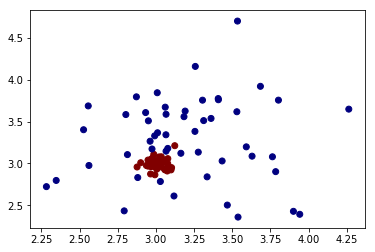

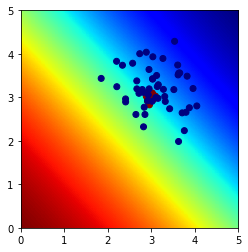

In [21]:
def generate_classification_data(N1, N2, K, sigma):
    mean = (3, 3)
    cov = [[0.003, 0], [0, 0.003]]
    X1 = random.multivariate_normal(mean, cov, N1)
    c1 = ['maroon'] * len(X1)

    mean = (3.2, 3.2)
    cov = [[0.3, 0], [0, 0.3]]
    X2 = random.multivariate_normal(mean, cov, N2)
    c2 = ['navy'] * len(X2)

    X = np.concatenate((X1, X2))
    color = np.concatenate((c1, c2))

    fig = plt.figure()
    plt.scatter(X[ : , 0], X[: , 1], marker='o', c=color, figure=fig)
    
    data = [X, X1, X2, color]
    return data

data = generate_classification_data(N1, N2, K, sigma)
X = data[0]
X1 = data[1]
X2 = data[2]
color = data[3]

T = calculate_T(X, X1, X2, K)

alpha=1.0
s0 = np.array([[alpha, 0], [0, alpha]])
phi = calculate_phi(X)
w_prior = np.zeros((K, 1))
w_map = newton_method(w_prior, s0, phi, T, 1)

Sn = calculate_Sn(w_map, phi, s0)

x = np.arange(0, 5, 0.01)
y = np.arange(0, 5, 0.01)

classify(x, y)
plot_classification(N1, N2, K, sigma)